In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
import seaborn as sns
import os
import datetime
import keras
import cv2
import h5py

/home/wurst/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wurst/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wurst/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wurst/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

In [2]:
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

print(tf.test.is_gpu_available())

True


In [3]:
keras.backend.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### Load images into RAM and scale them to a fixed size

In [4]:
images_size = 60 # width and height
images_shape = (images_size, images_size, 3)
images_shape_flat = images_shape[0] * images_shape[1] * images_shape[2]

scaled_faces = np.array([
    cv2.resize(cv2.cvtColor(cv2.imread('photos/faces_pure/' + f), cv2.COLOR_BGR2RGB), (images_size, images_size)) / 255
               for f in os.listdir('photos/faces_pure')
])

print(scaled_faces.shape)

(8423, 60, 60, 3)


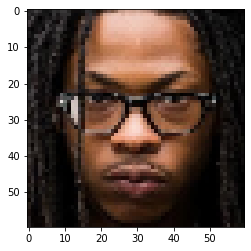

In [5]:
plt.imshow(scaled_faces[2])

### Train the model

In [6]:
use_convo = False
encoding_size = 30

if use_convo:
    enc_input = l = keras.layers.Input(shape=images_shape)
    l = keras.layers.Conv2D(16, (4, 4), activation='relu', padding='same')(l)
    l = keras.layers.MaxPooling2D((3, 3), padding='same')(l)
    l = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(l)
    l = keras.layers.MaxPooling2D((2, 2), padding='same')(l)
    l = keras.layers.Flatten()(l)
    l = keras.layers.Dense(encoding_size, activation='relu')(l)
    encoder = keras.models.Model(inputs=enc_input, outputs=l)

    dec_input = l = keras.layers.Input(shape=(encoding_size,))
    l = keras.layers.Dense(images_shape_flat, activation='relu')(l)
    l = keras.layers.Reshape(target_shape=images_shape)(l)
    l = keras.layers.Conv2D(16, (4, 4), activation='relu', padding='same')(l)
    l = keras.layers.MaxPooling2D((3, 3), padding='same')(l)
    l = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(l)
    l = keras.layers.MaxPooling2D((2, 2), padding='same')(l)
    l = keras.layers.Flatten()(l)
    l = keras.layers.Dense(images_shape_flat, activation='sigmoid')(l)
    l = keras.layers.Reshape(target_shape=images_shape)(l)
    decoder = keras.models.Model(inputs=dec_input, outputs=l)
else:
    enc_input = l = keras.layers.Input(shape=images_shape)
    l = keras.layers.Flatten()(l)
    l = keras.layers.Dense(800, activation='relu')(l)
    l = keras.layers.Dense(encoding_size, activation='relu')(l)
    encoder = keras.models.Model(inputs=enc_input, outputs=l)

    dec_input = l = keras.layers.Input(shape=(encoding_size,))
    l = keras.layers.Dense(800, activation='relu')(l)
    l = keras.layers.Dense(images_shape_flat, activation='sigmoid')(l)
    l = keras.layers.Reshape(target_shape=images_shape)(l)
    decoder = keras.models.Model(inputs=dec_input, outputs=l)

autocoder = keras.models.Model(inputs=enc_input, outputs=decoder(encoder(enc_input)))

autocoder.compile(optimizer='adadelta', loss='mse')

In [8]:
autocoder.fit(
    scaled_faces,
    scaled_faces,
    epochs=3000, 
    batch_size=256,
    shuffle=True
)

Epoch 1/100
8423/8423 [==============================] - 2s 183us/step - loss: 0.0516
Epoch 2/100
8423/8423 [==============================] - 1s 177us/step - loss: 0.0506
Epoch 3/100
8423/8423 [==============================] - 2s 180us/step - loss: 0.0499
Epoch 4/100
8423/8423 [==============================] - 2s 179us/step - loss: 0.0494
Epoch 5/100
8423/8423 [==============================] - 2s 179us/step - loss: 0.0490
Epoch 6/100
8423/8423 [==============================] - 2s 180us/step - loss: 0.0488
Epoch 7/100
8423/8423 [==============================] - 2s 179us/step - loss: 0.0487
Epoch 8/100
8423/8423 [==============================] - 2s 180us/step - loss: 0.0485
Epoch 9/100
8423/8423 [==============================] - 1s 177us/step - loss: 0.0484
Epoch 10/100
8423/8423 [==============================] - 1s 178us/step - loss: 0.0483
Epoch 11/100
8423/8423 [==============================] - 2s 180us/step - loss: 0.0482
Epoch 12/100
8423/8423 [============================

In [9]:
if use_convo:
    enc_name = 'convo_encoder60.keras'
    dec_name = 'convo_decoder60.keras'
else:
    enc_name = 'deep_encoder60.keras'
    dec_name = 'deep_decoder60.keras'

encoder.save(enc_name)
decoder.save(dec_name)
encoder = keras.models.load_model(enc_name)
decoder = keras.models.load_model(dec_name)

/home/wurst/.local/lib/python3.7/site-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


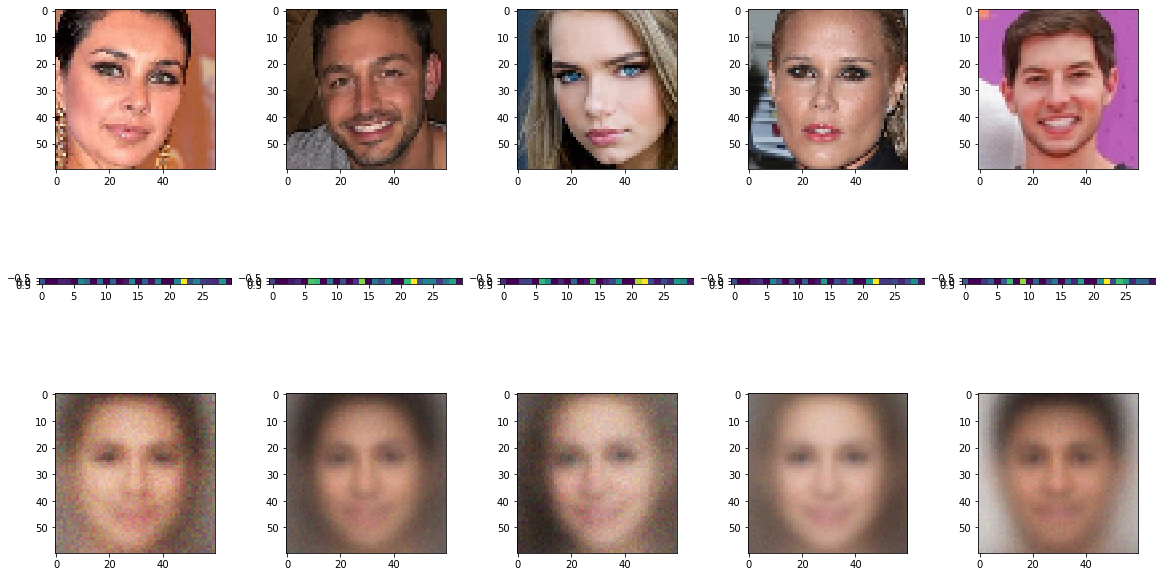

In [12]:
plt.figure(figsize=(20, 10))

n = 5

for i, img in enumerate(scaled_faces[np.random.randint(len(scaled_faces), size=n), :, :, :]):
    encoded = encoder.predict(img.reshape(1, *images_shape))[0]
    decoded = decoder.predict(encoded.reshape(1, -1))[0]
    
    plt.subplot(3, n, i+1)
    plt.imshow(img)
    
    plt.subplot(3, n, i+n+1)
    plt.imshow(encoded.reshape(1, -1))

    plt.subplot(3, n, i+n+n+1)
    plt.imshow(decoded)